1. Image Analytics Theme (Minsoo)

  1) Image pre-processing and transformation

     (1) Write code to randomly rotate, shift, scale and warp the image of the patches. Thus generate 100 images

In [1]:
#Import packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import math
import copy
import json
from google.colab.patches import cv2_imshow
from skimage.io import imread
from skimage import data, io
import random
from PIL import Image, ImageOps, ImageChops
from sklearn.feature_extraction.image import extract_patches_2d
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch


In [2]:
!pip install kornia numpy matplotlib
!pip install patchify
import kornia as K


     |████████████████████████████████| 474 kB 5.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Rotate image definition

def rotate_image(image, angle):
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = warpAffine(image, M, (nW, nH), False)

    # image = cv2.resize(image, (w,h))

    return image

## WarpAffine Definition
def warpAffine(src, M, dsize, from_bounding_box_only=False):

    return cv2.warpAffine(src, M, dsize)

## Crop_to_Center Definition
def crop_to_center(old_img, new_img):
 
    if isinstance(old_img, tuple):
        original_shape = old_img
    else:
        original_shape = old_img.shape
    original_width = original_shape[1]
    original_height = original_shape[0]
    original_center_x = original_shape[1] / 2
    original_center_y = original_shape[0] / 2

    new_width = new_img.shape[1]
    new_height = new_img.shape[0]
    new_center_x = new_img.shape[1] / 2
    new_center_y = new_img.shape[0] / 2

    new_left_x = int(max(new_center_x - original_width / 2, 0))
    new_right_x = int(min(new_center_x + original_width / 2, new_width))
    new_top_y = int(max(new_center_y - original_height / 2, 0))
    new_bottom_y = int(min(new_center_y + original_height / 2, new_height))

    # create new img canvas
    canvas = np.zeros(original_shape)

    left_x = int(max(original_center_x - new_width / 2, 0))
    right_x = int(min(original_center_x + new_width / 2, original_width))
    top_y = int(max(original_center_y - new_height / 2, 0))
    bottom_y = int(min(original_center_y + new_height / 2, original_height))

    canvas[top_y:bottom_y, left_x:right_x] = new_img[new_top_y:new_bottom_y, new_left_x:new_right_x]

    return canvas



In [5]:
# Pad_vector
def pad_vector(vector, how, depth, constant_value=0):
    vect_shape = vector.shape[:2]
    if (how == 'upper') or (how == 'top'):
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(pp, vector))
    elif (how == 'lower') or (how == 'bottom'):
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(vector, pp))
    elif (how == 'left'):
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(pp, vector))
    elif (how == 'right'):
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(vector, pp))
    else:
        return vector
    return pv

# Read
def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

# Shifter

def shifter(vect, y, y_):
    if (y > 0):
        image_trans = pad_vector(vector=vect, how='lower', depth=y_)
    elif (y < 0):
        image_trans = pad_vector(vector=vect, how='upper', depth=y_)
    else:
        image_trans = vect
    return image_trans

# Shift_image
def shift_image(image_src, at):
    x, y = at
    x_, y_ = abs(x), abs(y)

    if (x > 0):
        left_pad = pad_vector(vector=image_src, how='left', depth=x_)
        image_trans = shifter(vect=left_pad, y=y, y_=y_)
    elif (x < 0):
        right_pad = pad_vector(vector=image_src, how='right', depth=x_)
        image_trans = shifter(vect=right_pad, y=y, y_=y_)
    else:
        image_trans = shifter(vect=image_src, y=y, y_=y_)

    return image_trans

# Shift 
def translate_this(image_file, at, with_plot=False, gray_scale=False):
    if len(at) != 2: return False

    image_src = read_this(image_file=image_file, gray_scale=gray_scale)

    if not gray_scale:
        r_image, g_image, b_image = image_src[:, :, 0], image_src[:, :, 1], image_src[:, :, 2]
        r_trans = shift_image(image_src=r_image, at=at)
        g_trans = shift_image(image_src=g_image, at=at)
        b_trans = shift_image(image_src=b_image, at=at)
        image_trans = np.dstack(tup=(r_trans, g_trans, b_trans))
    else:
        image_trans = shift_image(image_src=image_src, at=at)

    if with_plot:
        cmap_val = None if not gray_scale else 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

        ax1.axis("off")
        ax1.title.set_text('Original')

        ax2.axis("off")
        ax2.title.set_text("Translated")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_trans, cmap=cmap_val)
        return True
    return image_trans





Image Handling examples

1) Rotation

2) Shift

3) Scale 

In [12]:
#Rotation Example (Change x in rotate_image(im, x) to set the angle)

#img_path = '/content/drive/MyDrive/Homework_2/eia/leaves/I1.png'
#im = imread(img_path).astype(np.float64) / 255

#rotated = crop_to_center(im, rotate_image(im, 59))

#io.imshow(rotated)
#plt.show()

#Shift Example
#    img = cv2.imread(img_path)
#    height, width = img.shape[:2]
#    tx, ty = width / random.randint(1,10), height / random.randint(1,10)
#    translation_matrix = np.array([
#                                   [1,0, tx],
#                                   [0, 1, ty]
#    ], dtype=np.float32)
#    translated_image = cv2.warpAffine(src=img, M=translation_matrix, dsize=(width, height))
#    cv2.imshow('Translated image', translated_image)

# Scale example

#img = cv2.imread(img_path,1)
#cv2_imshow(img)

#img_stretch = cv2.resize(img, (600,600))
#cv2_imshow(img_stretch)


In [6]:
# Code Process
# 1) Select Image Randomly 
# 2) Select Methods Randomly among three methods (Rotation, Shift, and Scale)

img_pathlist = ['/content/drive/MyDrive/Homework_2/eia/leaves/I1.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I2.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I3.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I4.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I5.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I6.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I7.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I8.png']

for x in range(100):
  img_path = img_pathlist[random.randint(0,7)]
  randvalue = random.randint(0,2)

  if  randvalue == 0:
    img = imread(img_path).astype(np.float64) / 255
    rotated = crop_to_center(img, rotate_image(img, random.randint(1,359)))
    io.imshow(rotated)
    plt.show()
    del img

  elif randvalue == 1:
    img = cv2.imread(img_path,1)
    height, width = img.shape[:2]
    tx, ty = width / random.randint(1,10), height / random.randint(1,10)
    translation_matrix = np.array([
                                   [1,0, tx],
                                   [0, 1, ty]
    ], dtype=np.float32)
    translated_image = cv2.warpAffine(src=img, M=translation_matrix, dsize=(width, height))
    cv2_imshow(translated_image)
    del img

  else:
    img = cv2.imread(img_path,1)
    img_stretch = cv2.resize(img, (random.randint(0,1000), random.randint(0,1000)))
    cv2_imshow(img_stretch)
    del img

  print(x)

Output hidden; open in https://colab.research.google.com to view.

2) Obtain local patches (of a certain fixed size of your choice, much smaller than the original image size) from all the leaf images

In [7]:
# Image list
img_pathlist = ['/content/drive/MyDrive/Homework_2/eia/leaves/I1.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I2.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I3.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I4.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I5.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I6.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I7.png', '/content/drive/MyDrive/Homework_2/eia/leaves/I8.png']
!mkdir Patches
for x in range(8):
    img_path = img_pathlist[x]
    leaf = cv2.imread(img_path)
    dpi = 100
    plot_width, plot_height = leaf.shape[1], len(leaf)
    width_inches, height_inches = plot_width/dpi, plot_height/dpi
    plt.figure(figsize=(width_inches, height_inches), dpi=dpi, facecolor='w', edgecolor='k', frameon=False)
    #Modify patch_size based on each image frame
    patches = extract_patches_2d(leaf, patch_size=(int(leaf.shape[1]/3), int(int(len(leaf))/3)), max_patches=9)
    # Save patches as images
    for i, patch in enumerate(patches):
        im = Image.fromarray(patch, 'RGB')
        im.save('Patches/patch%d-%d.jpg' % (x,i))  
    # Show original image
    plt.imshow(leaf)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    # Show patches in a 3x3 grid
    gridx, gridy = 3, 3
    fig, ax = plt.subplots(gridx, gridy, figsize=(width_inches, height_inches), dpi=dpi, facecolor='w', edgecolor='k', frameon=False)
    for i in range(gridx):
        for j in range(gridy):
            im = np.array(Image.open('Patches/patch%d-%d.jpg' % (x,3*i + j)))
            ax[i, j].axis('off')
            ax[i, j].imshow(im)     
    # Save grid as image
    plt.savefig('image_grid%d.jpg' %(x,), dpi=dpi, bbox_inches='tight', transparent=True)
    # Show grid
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

3) Prewhiten (using ZCA whitening) the patches

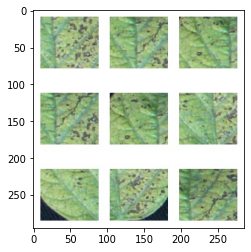

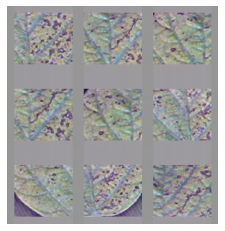

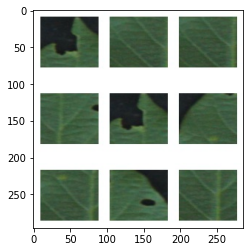

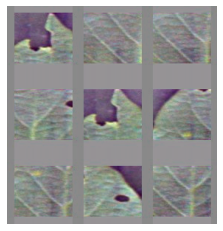

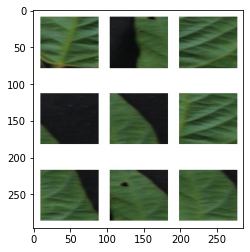

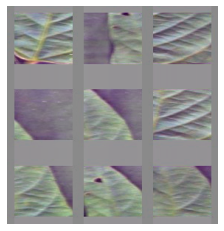

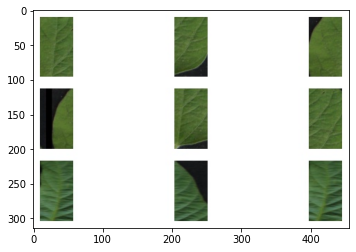

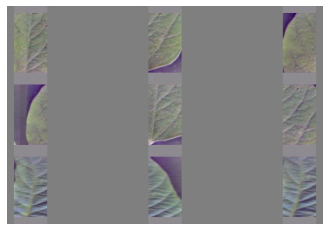

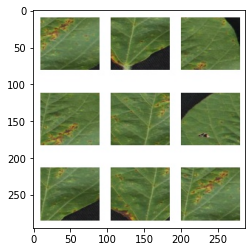

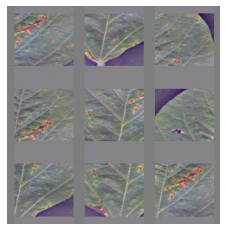

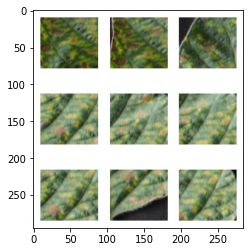

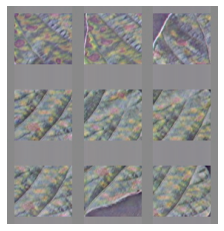

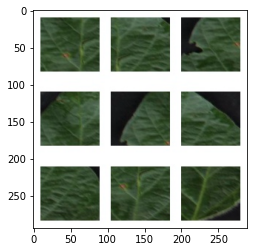

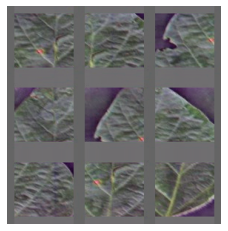

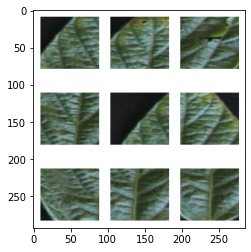

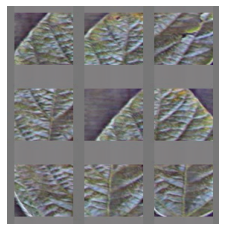

In [14]:
# Each leaf prewhiten
img_pathlist = ['/content/image_grid0.jpg', '/content/image_grid1.jpg', '/content/image_grid2.jpg', '/content/image_grid3.jpg', '/content/image_grid4.jpg', '/content/image_grid5.jpg', '/content/image_grid6.jpg', '/content/image_grid7.jpg']
for x in range(8):
      img_path = img_pathlist[x]
      image = cv2.imread(img_path)
      normalized_image = image/255
      normalized_image = normalized_image.astype(np.float32)
      torched_image = torch.from_numpy(normalized_image)
      zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
      zca.fit(torched_image)
      zca_image = zca(torched_image)
      zca_image = make_grid(zca_image, nrow=1, normalize=True).cpu().numpy()
      plt.imshow(torched_image)
      plt.show()
      plt.axis('off')
      plt.imshow(zca_image)
      plt.savefig('Prewhitenimage%d.jpg' %(x,), dpi=dpi, bbox_inches='tight', transparent=True)
      plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


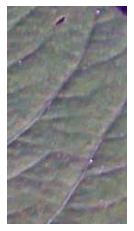

In [9]:
# Each patch prewhitening and saving without showing
import os
img_pathlist = os.listdir('/content/Patches')
!mkdir PrewhitendPatches
a = int(len(img_pathlist))
for x in range(a):
      img_path = os.path.join('/content/Patches', img_pathlist[x])
      image = cv2.imread(img_path)
      normalized_image = image/255
      normalized_image = normalized_image.astype(np.float32)
      torched_image = torch.from_numpy(normalized_image)
      zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
      zca.fit(torched_image)
      zca_image = zca(torched_image)
      zca_image = make_grid(zca_image, nrow=1, normalize=True).cpu().numpy()
      plt.axis('off')
      plt.imshow(zca_image)
      plt.savefig('PrewhitendPatches/Prewhiten%s' %(img_pathlist[x],), dpi=dpi, bbox_inches='tight', transparent=True)
      print(x)

4) and 5) Determine the channel-by-channel distribution of the prewhitened images and the original images

In [10]:
# Channel-by-Channel distribution definition
def plot_image_with_RGB_distribution(img):
  # Split
  red = img[:, :, 0]
  green = img[:, :, 1]
  blue = img[:, :, 2]
  fig, axs = plt.subplots(2,2)

  cax_00 = axs[0,0].imshow(img)
  axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
  axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

  cax_01 = axs[0,1].imshow(red, cmap='Reds')
  fig.colorbar(cax_01, ax=axs[0,1])
  axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
  axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

  cax_10 = axs[1,0].imshow(green, cmap='Greens')
  fig.colorbar(cax_10, ax=axs[1,0])
  axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
  axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

  cax_11 = axs[1,1].imshow(blue, cmap='Blues')
  fig.colorbar(cax_11, ax=axs[1,1])
  axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
  axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
  plt.show()

  # Plot histograms
  fig, axs = plt.subplots(3, sharex=True, sharey=True)

  axs[0].hist(red.ravel(), bins=10)
  axs[0].set_title('Red')
  axs[1].hist(green.ravel(), bins=10)
  axs[1].set_title('Green')
  axs[2].hist(blue.ravel(), bins=10)
  axs[2].set_title('Blue')

  plt.show()

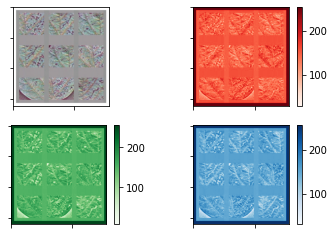

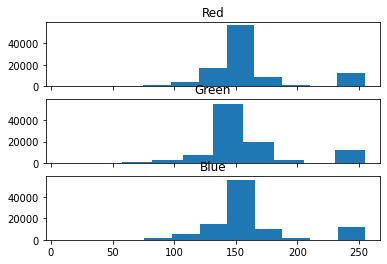

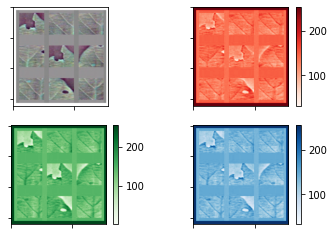

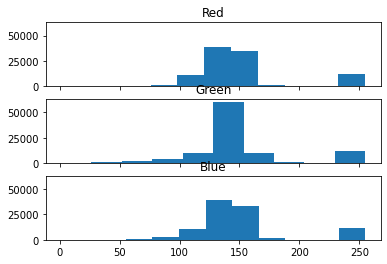

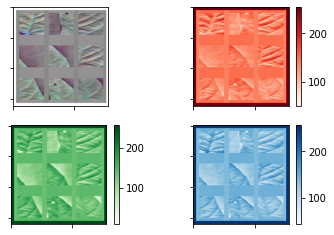

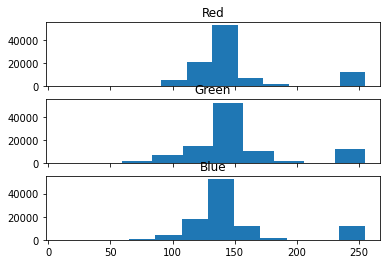

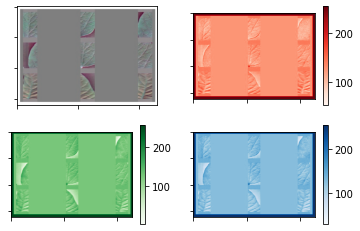

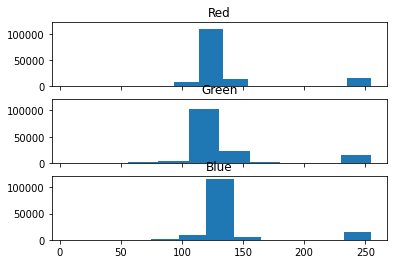

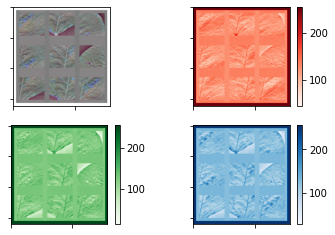

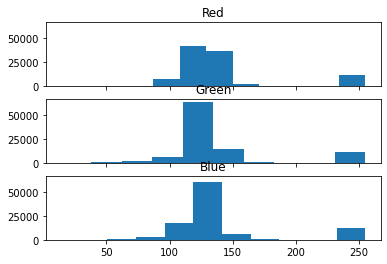

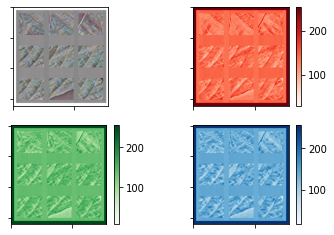

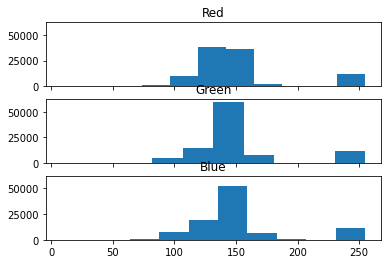

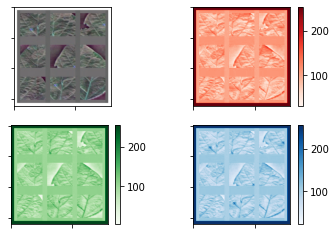

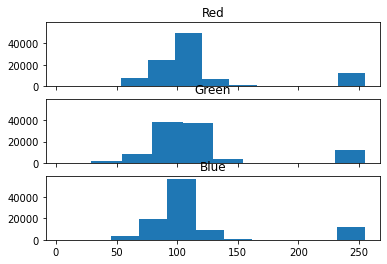

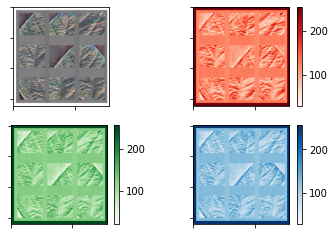

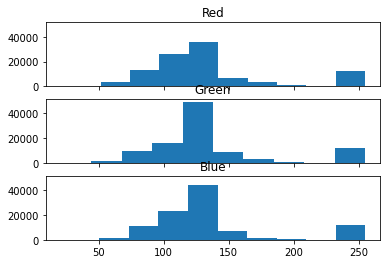

In [15]:
# 4) Prewhitened images distribution

img_pathlist = ['/content/Prewhitenimage0.jpg', '/content/Prewhitenimage1.jpg', '/content/Prewhitenimage2.jpg', '/content/Prewhitenimage3.jpg', '/content/Prewhitenimage4.jpg', '/content/Prewhitenimage5.jpg', '/content/Prewhitenimage6.jpg', '/content/Prewhitenimage7.jpg']
for x in range(8):
      img_path = img_pathlist[x]
      image = cv2.imread(img_path)
      plot_image_with_RGB_distribution(image)
      

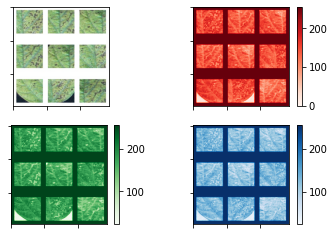

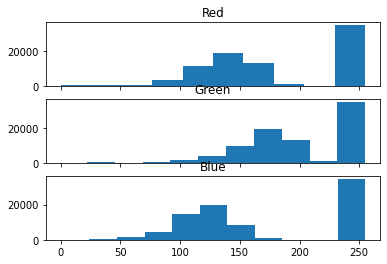

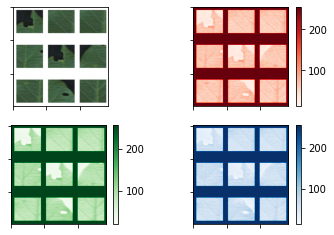

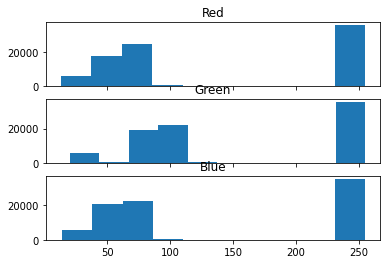

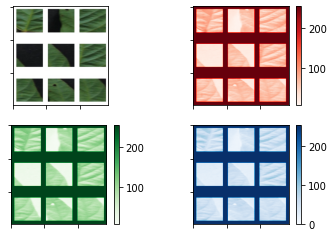

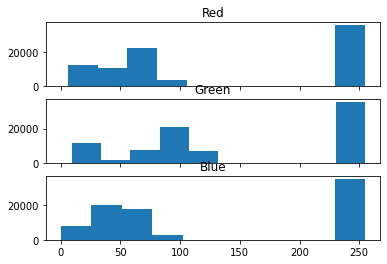

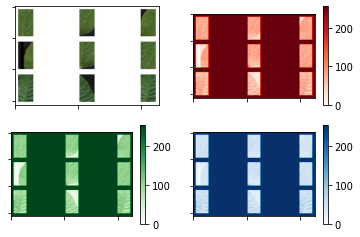

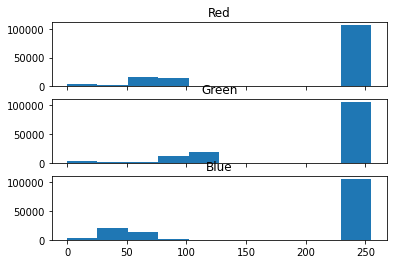

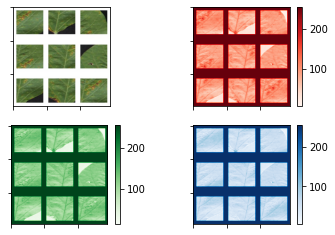

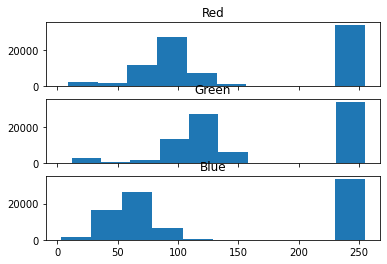

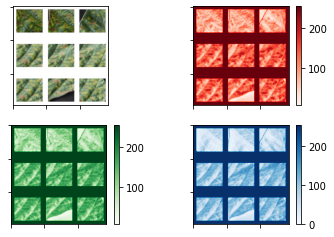

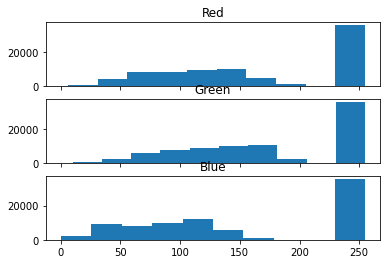

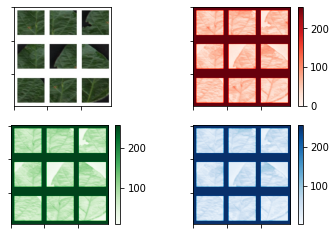

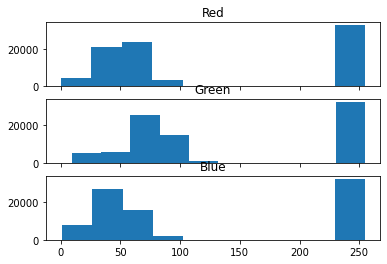

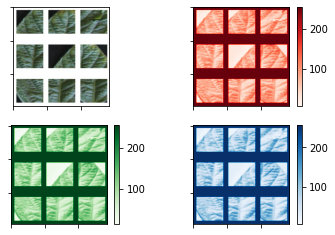

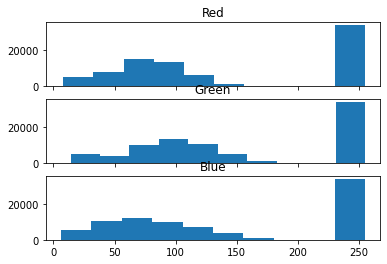

In [16]:
# 5) Original images distribution

img_pathlist = ['/content/image_grid0.jpg', '/content/image_grid1.jpg', '/content/image_grid2.jpg', '/content/image_grid3.jpg', '/content/image_grid4.jpg', '/content/image_grid5.jpg', '/content/image_grid6.jpg', '/content/image_grid7.jpg']
for x in range(8):
      img_path = img_pathlist[x]
      image = cv2.imread(img_path)
      plot_image_with_RGB_distribution(image)


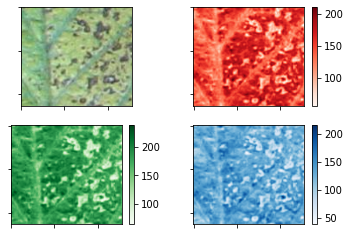

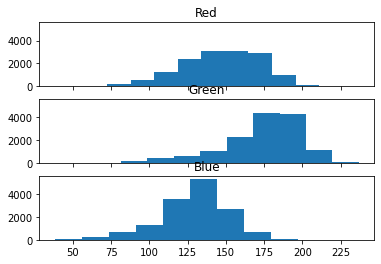

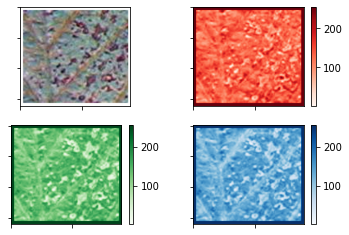

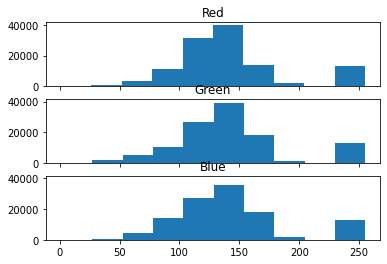

In [17]:
#A patch example applying channel-by-channel distribution
image = cv2.imread('/content/Patches/patch0-0.jpg')
plot_image_with_RGB_distribution(image)
image2 = cv2.imread('/content/PrewhitendPatches/Prewhitenpatch0-0.jpg')
plot_image_with_RGB_distribution(image2)